# Figure 2

This script contains the analysis for the Markov modelling in Figure 2.  


### Load Modules

In [1]:
from markov_simulator_dynamic_14March23_Jax_deep import Markov_fit
from markov_simulator_dynamic_14March23_Jax_deep import make_extent
import Figure_2_functions as PF

import importlib
importlib.reload(PF)

import os
import pandas as pd
import seaborn as sns
import pickle as pickle
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

ingeo_colours = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", "#BBBBBB", "#5D55A4"]


## Figure 2A-B - Schematics of hypothesis and modelling pipeline. 

Schematics were made in illustrator.

Schematics can be found at: `Figure_2\All_panels\Figure_2A` and `Figure_2\All_panels\Figure_2B`.

## Running Markov modelling pipeline.

The modelling was performed using a jax deep learning framework specified in `markov_simulator_dynamic_14March23_Jax_deep.py`.  

**Quick Start:**

 - To run the modelling pipeline requires a `data` folder containing cell fate measurements `proportions.csv` and signalling conditions.  

 - Results are saved to a `results` folder. 

 - Hypothesis of potential topologies is contained within a `Hypothesis.csv` folder.

 - This is contained within an overal simulation folder e.g. `DRonly` (Dose response only fitting).
 
 - Running `Create_Bash.ipynb` generates a series of bash files containing parameters for all models. 
 
 - Key parameters to adjust are `proportion_weight` and `switching_weight` adjusted to contribution of two datasets (e.g. `"proportion_weight":1`)
 
 - `Launch.sh` is used to launch hypothesis files e.g. (`H0.sh`) to HPC cluster.


## Import modelling data 

Importing all modelling data for generating plots in Figure 2.

In [6]:
results = glob.glob(os.path.join("Figure_2C-G_S2B-H_AllModelling/DRonly/results/*"))

df = PF.import_modelling_residuals(results)

###################################################################
### Select best fits for each topology across initialisations #####
###################################################################

df_best = PF.select_best_residuals(df)

#############################################################################
### Import hypothesis and calculate number of parameters for correction #####
#############################################################################

hypo_ = pd.read_csv("Figure_2C-G_S2B-H_AllModelling/DRonly/Hypothesis.csv")
hypo_['hyp'] = hypo_['Topology_Name']
hypo = hypo_[['Topology_number', 'hyp','Convergence_dir']]

hypo_['par_num'] = [len(i)*5 for i in hypo_['Transitions'].str.split(',')]
num_params_dict = dict(zip(hypo_['hyp'], hypo_['par_num']))

## Calculate Akaike information criterion (AIC) 

AIC is calculated as: `2 * num_params + num_observations * np.log(rss / num_observations)`



In [7]:
# Group by model hypothesis and calculate AIC for each model
aic_results = []

for hyp, group in df_best.groupby('hyp'):
    rss = group['residual'].values
    num_observations = 25
    num_params = num_params_dict.get(hyp, None)  # Get number of parameters for the model hypothesis

    if num_params is not None:
        aic_value = PF.calculate_aic(rss, num_params, num_observations)
        aic_results.append({'hyp': hyp, 'AIC': aic_value[0], 'N_params': num_params})

# Convert results to DataFrame for easy viewing
aic_df = pd.DataFrame(aic_results)

aic_df["Topology_Name"] = aic_df["hyp"]
df_best["Topology_Name"] = df_best["hyp"]

df_best = df_best[['Topology_Name','residual']].merge(aic_df, on='Topology_Name', how='left')
df_best = hypo_[['Topology_Name','Topology_number']].merge(df_best, on='Topology_Name', how='left')

# Removing 'T' from each element
stripped_list = [item.lstrip('T') for item in df_best['Topology_number']]
number_list = [int(num) for num in stripped_list]

df_best['Topology_num'] = number_list

df_best = df_best.loc[df_best['Topology_num']<=38]

## Figure 2C - Ranking best fits by AIC:

Text(0, 0.5, 'AIC')

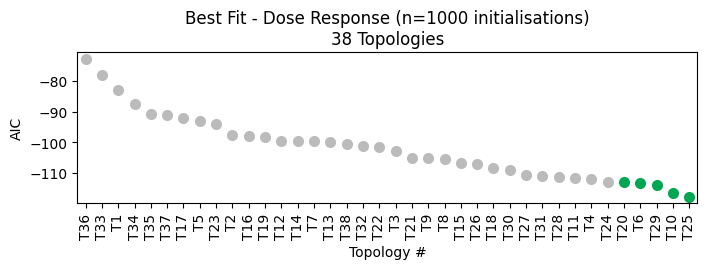

In [11]:
df_best = df_best.sort_values('AIC', ascending=False)
df_best['hit'] = 'not hit'
# Set last 5 rows to "hit"
df_best.loc[df_best.tail(5).index, 'hit'] = 'hit'

plt.figure(figsize=(8,2), dpi=100)
ax=sns.stripplot(data=df_best, x='Topology_number', y='AIC', edgecolor = "white", hue='hit',
size = 8, jitter = 0, zorder = 1, alpha=1, order=list(df_best['Topology_number']), palette=[ingeo_colours[6],'#00A651'])

plt.xticks(rotation=90)
plt.title("Best Fit - Dose Response (n=1000 initialisations)\n38 Topologies")

plt.legend().remove()
plt.xlabel("Topology #")
plt.ylabel("AIC")
#plt.savefig("residuals_AIC.pdf")

## Figure 2D - Simulations of top topologies (T1, T5 and T6):

Plotting individual topology simulations.

Final panels for these data can be found in `Figure_2\All_panels\Figure_2D` including drawings of topologies.

Code chunk for saving multiple heatmaps at once can be found in `Figure_2_Plotting_functions.py`

N.B. "ME" states were revised to "I" for intermediate in final manuscript.

#### Topology 1

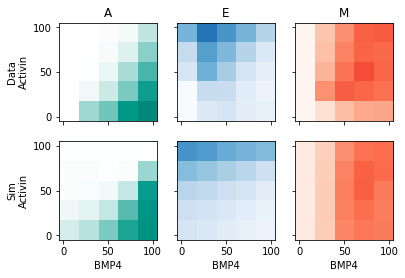

In [12]:
top = 'T1'
data_path = 'Figure_2C-G_S2B-H_AllModelling/DRonly'

PF.plotting_modelling_heatmaps(top, hypo_, data_path)


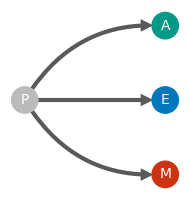

In [13]:
connection_styles = ["arc3,rad=0.3", "arc3,rad=-0","arc3,rad=-0.3"]
PF.plot_topology_network(hypo_, top, connection_styles)

#### Topology 5

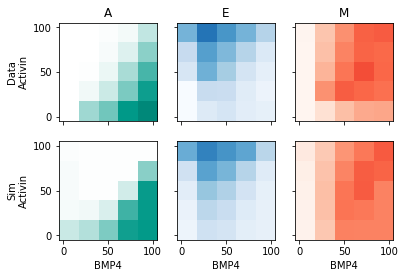

In [14]:
top = 'T5'
data_path = 'Figure_2C-G_S2B-H_AllModelling/DRonly'

PF.plotting_modelling_heatmaps(top, hypo_, data_path)


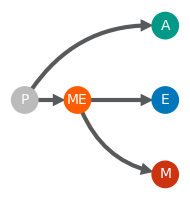

In [15]:
connection_styles = ["arc3,rad=0", "arc3,rad=-0.3","arc3,rad=0.3","arc3,rad=0"]
PF.plot_topology_network(hypo_, top, connection_styles)

#### Topology 6

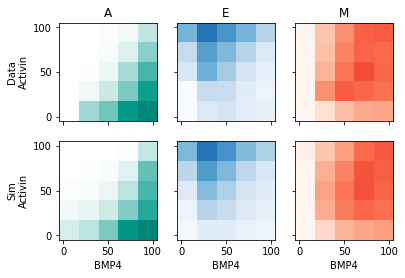

In [16]:
top = 'T6'
data_path = 'Figure_2C-G_S2B-H_AllModelling/DRonly'

PF.plotting_modelling_heatmaps(top, hypo_, data_path)


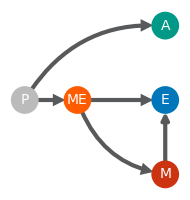

In [17]:
PF.plot_topology_network(hypo_, top, connection_styles)

## Figure 2E - Validation of topologies with switching data:

To validate topologies from dose response fits we simulate switching responses for all topologies and then score again using AIC based on observed measurements. This allows us to assess the predictive power of each model.

Details of the validation function can be found in `Figure_2_functions`

#### Dynamic simulations:

In [18]:
df_best = df_best.reset_index()

In [19]:
cost_dynamic_list = PF.validation_dynamic_simulation(df_best, "Figure_2C-G_S2B-H_AllModelling/DRonly/")

Processing simulations: 100%|██████████| 38/38 [01:27<00:00,  2.31s/it]


In [20]:
df_best['residual_dynamic'] = cost_dynamic_list
order = df_best.sort_values('residual_dynamic')['Topology_number']
df_best = df_best.sort_values('residual_dynamic', ascending=False)
df_best = df_best.reset_index()
df_best_hit = df_best.loc[df_best['hit']=='hit']

#### AIC calculations:

In [21]:
# Group by model hypothesis and calculate AIC for each model
aic_results = []

for hyp, group in df_best.groupby('hyp'):
    rss = group['residual_dynamic'].values
    num_observations = 33
    num_params = num_params_dict.get(hyp, None)  # Get number of parameters for the model hypothesis

    if num_params is not None:
        aic_value = PF.calculate_aic(rss, num_params, num_observations)
        aic_results.append({'Topology_Name': hyp, 'AIC_dynamic': aic_value[0], 'N_params': num_params})

# Convert results to DataFrame for easy viewing
aic_df_dynamic = pd.DataFrame(aic_results)

<ipython-input-22-e00a01aad1ee>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.stripplot(data=df_best_hit, x='Topology_number', y='AIC_dynamic' , size = 12,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'AIC')

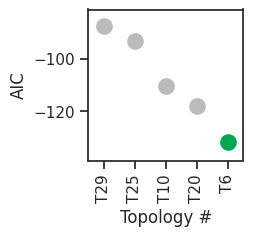

In [22]:
df_best = df_best.merge(aic_df_dynamic, on='Topology_Name', how='left')
df_best = df_best.sort_values(["AIC_dynamic"], ascending=False)
df_best_hit = df_best.loc[df_best['hit']=='hit']
plt.figure(figsize=(2,2), dpi=100)


sns.set_theme(style="ticks")
## Stripplot and Boxplot

ax=sns.stripplot(data=df_best_hit, x='Topology_number', y='AIC_dynamic' , size = 12, 
                palette=[ingeo_colours[6],ingeo_colours[6],ingeo_colours[6],ingeo_colours[6],'#00A651']).set(ylim=(-139,-81))
plt.xticks(rotation=90)
plt.legend().remove()
plt.xlabel("Topology #")
plt.ylabel("AIC")


## Figure 2F - Simulation of switching data 

For top topology T6 switching proportions are simulated.

In [ ]:
top = 'T6'

sim = list(hypo_.loc[hypo_["Topology_number"]==top]['Topology_Name'])[0]
d = pd.read_csv(glob.glob(os.path.join('Figure_2C-G_S2B-H_Modelling_fits/DRandS/results', sim,'*',"results/residuals.csv"))[0]).sort_values("residual")
d['hyp'] = sim
print(sim)
d = d.reset_index()
k = d.loc[0]['index']


#### Individual dynamic simulations with proportions:

In [ ]:
##########################
### Simulate switching ###
##########################

chosen_initialisation_index = k
sP = markov_fit.sP_opts[chosen_initialisation_index]

signalling_parameters = sP.reshape(5,-1)
#signalling_parameters = np.zeros((5,_signalling_parameters.shape[1]))
#signalling_parameters[:3] = _signalling_parameters[:3]
#signalling_parameters[4] = _signalling_parameters[3]
mrkvS = markov_fit.mrkvSs[chosen_initialisation_index]
mrkvS.signalling_parameters = signalling_parameters
mrkvS.make_transition_matrices()
mrkvS.make_transition_matrices_dynamic()

mrkvS.simulate()
mrkvS.simulate_dynamic()

s_solve_dynamic = mrkvS.s_solve_dynamic.reshape(mrkvS.s_solve_dynamic.shape[0],mrkvS.D_init.shape[0],-1)
s_solve = mrkvS.s_solve.reshape(mrkvS.s_solve.shape[0],mrkvS.D.shape[0],-1)

total_proportions = {}
for data_name in markov_fit.data_names:
    total_proportions[data_name] = np.zeros_like(mrkvS.final_vals[0])
for state_name in markov_fit.state_names:
    total_proportions[markov_fit.dictionary[state_name]] += mrkvS.final_vals[mrkvS.markov.states.index(state_name)]

total_proportions_dynamic = {}
for data_name in markov_fit.data_names:
    total_proportions_dynamic[data_name] = np.zeros_like(mrkvS.final_vals_dynamic[0])
for state_name in markov_fit.state_names:
    total_proportions_dynamic[markov_fit.dictionary[state_name]] += mrkvS.final_vals_dynamic[
        mrkvS.markov.states.index(state_name)]

cost_dynamic = 0
for key, val in total_proportions_dynamic.items():
    cost_dynamic += (np.abs(val - markov_fit.df_dynamic[key].values / 100) ** 2).sum()
    
print(cost_dynamic)

##########################
### Structure sim data ###
##########################

sim_data = pd.DataFrame({'A':s_solve_dynamic[-1,:][:,0]*100,
                   'E':s_solve_dynamic[-1,:][:,1]*100,
                   'M':s_solve_dynamic[-1,:][:,2]*100,
                    'N' :np.sum(s_solve_dynamic[-1,:][:,3:], axis=1)*100,
                    'a_init': list(mrkvS.dynamic_signalling_params['a_init'][:]),
                    'b_init': list(mrkvS.dynamic_signalling_params['b_init'][:]),
                    'a_fin': list(mrkvS.dynamic_signalling_params['a_fin'][:]),
                    'b_fin': list(mrkvS.dynamic_signalling_params['b_fin'][:]),
                    't_change': list(mrkvS.dynamic_signalling_params['t_change'][:])}
                 )

sim_data['t_change'] = sim_data['t_change']*24
sim_data['t_change'] = sim_data['t_change'].astype(int)
sim_data.loc[(sim_data.index==0), 't_change'] = 'S'
sim_data.loc[(sim_data.index==4), 't_change'] = 'S'
sim_data.loc[(sim_data.index==8), 't_change'] = 'U'

sim_data['Condition'] = "A" + sim_data['a_init'].astype(str) + "_" + "B" + sim_data['b_init'].astype(str) +"_"+ sim_data['t_change'].astype(str)

###########################
### Structure real data ###
###########################

data = pd.read_csv("Figure_2C-G_S2B-H_Modelling_fits/DRandS/data/switching_data.csv")
data['N'] = 100 - (data['M'] + data['A'] + data['E'])

data['t_change'] = data['t_change']*24
data['t_change'] = data['t_change'].astype(int)

data.loc[(data.index==0), 't_change'] = 'S'
data.loc[(data.index==4), 't_change'] = 'S'
data.loc[(data.index==8), 't_change'] = 'U'

data['Condition'] = "A" + data['a_init'].astype(str) + "_" + "B" + data['b_init'].astype(str) +"_"+ data['t_change'].astype(str)

#### Activin to BM:

Text(0.5, 1.0, 'Activin to BMP4')

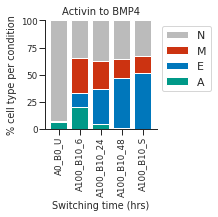

In [124]:
selection = ["A0_B0_U", "A100_B10_6","A100_B10_24","A100_B10_48","A100_B10_S"]

sim_data_sub = sim_data.loc[sim_data['Condition'].isin(selection)]
df = sim_data_sub[["Condition","A","E","M","N"]]
order= selection

df = df.loc[df['Condition'].isin(order)]
df = df.set_index("Condition").loc[order]
df_means = df.groupby("Condition").mean()
df_means = df_means.reset_index()
df_means = df_means.set_index('Condition').loc[order]

with sns.plotting_context("notebook", font_scale=0.8):
    PF.create_stack_bar_plot(
        df_means,
        x_figSize=2,
        y_figSize=2,
        color_pal=[ingeo_colours[2], ingeo_colours[0], ingeo_colours[4], ingeo_colours[6]],
        bar_width=0.8,
        y_label="% cell type per condition",
        x_label="Switching time (hrs)"
    )
    
##Adjustments

plt.ylim(0,100)
plt.title( "Activin to BMP4", fontsize=10)